# Example modeling process

### Imports

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from helpers import (get_training_observations, 
                     get_training_labels, 
                     get_protein_proportions)
import pandas as pd
import numpy as np
from joblib import dump
from joblib import load

# Model specific imports
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import xgboost as xgb
from xgboost import plot_tree
import matplotlib.pyplot as plt
import time

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Load training data and labels

In [2]:
x_train = get_training_observations()
y_train = get_training_labels()
le = load('../model_joblibs/xgb_labelEncoder.joblib')

Getting all training observations from 'metagenome_classification.db'...
Getting all training labels from 'metagenome_classification.db'...


In [5]:
x_train.head(10)

index,PF00001.19,PF00002.22,PF00003.20,PF00004.27,PF00005.25,PF00006.23,PF00007.20,PF00008.25,PF00009.25,PF00010.24,...,PF17216.1,PF17217.1,PF17218.1,PF17219.1,PF17220.1,PF17221.1,PF17222.1,PF17223.1,PF17224.1,PF17225.1
0,0.000000e+00,0.000000e+00,0.0,0.004020,0.006243,0.001039,0.0,0.000000,0.003265,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000e+00,0.000000e+00,0.0,0.003575,0.013739,0.001026,0.0,0.000000,0.002235,0.000007,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.376880e-07,2.188440e-07,0.0,0.001619,0.016218,0.000916,0.0,0.000002,0.001711,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000e+00,0.000000e+00,0.0,0.002737,0.019874,0.001785,0.0,0.000000,0.003570,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000e+00,0.000000e+00,0.0,0.001992,0.012389,0.001154,0.0,0.000013,0.002286,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000e+00,0.000000e+00,0.0,0.001684,0.016435,0.000931,0.0,0.000000,0.001806,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.000000e+00,0.000000e+00,0.0,0.001404,0.023274,0.000845,0.0,0.000000,0.001497,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.000000e+00,0.000000e+00,0.0,0.002301,0.015752,0.000925,0.0,0.000000,0.001843,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.000000e+00,0.000000e+00,0.0,0.001885,0.014797,0.001012,0.0,0.000000,0.001689,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.000000e+00,0.000000e+00,0.0,0.004574,0.013601,0.000995,0.0,0.000000,0.002402,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
y_train.head()

index,EMPO_1,EMPO_2,EMPO_3
0,Free-living,Saline,Hypersaline (saline)
1,Free-living,Saline,Water (saline)
2,Host-associated,Plant,Plant rhizosphere
3,Free-living,Non-saline,Soil (non-saline)
4,Free-living,Saline,Water (saline)


In [18]:
len(x_train.columns)

16306

### Data manipulation
Validation splits, dimensionality reduction, etc

In [3]:
y_train['EMPO_3'] = le.transform(y_train['EMPO_3'])
y_train['EMPO_3'].head()

0     3
1    14
2     5
3     9
4    14
Name: EMPO_3, dtype: int64

In [4]:
# Split into train/validation if not CV
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train['EMPO_3'], test_size=0.2, random_state=0)
# for hyperparameter tuning later
dtrain = xgb.DMatrix(x_tr, label=y_tr)
dval = xgb.DMatrix(x_val, label=y_val)

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


## Baseline

In [22]:
# function to plot the logloss
def eval_graphs(model):
    results = model.evals_result()
    x_arr = np.arange(len(results['validation_0']['mlogloss']))+1
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, results['validation_0']['mlogloss'], label='Train loss')
    ax.plot(x_arr, results['validation_1']['mlogloss'], label='Validation loss')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)
    plt.title('Model LogLoss Curve')
    plt.show()
    
def eval_score(model, x_tr=x_tr, y_tr=y_tr, eval_set=[(x_tr, y_tr), (x_val, y_val)], x_true=x_val, y_true=y_val):
    start = time.time()
    model.fit(x_tr,y_tr,
              eval_set=eval_set,
              early_stopping_rounds=10,
              verbose=0)
    stop = time.time()
    # predict validation data
    y_pred = model.predict(x_true)
    # print accuracy score 
    print("Training Set Accuracy Score on EMPO 3: ", accuracy_score(y_true, y_pred))
    # print model training time
    print(f"Baseline Model Training Time: {stop-start}s")
    return y_pred

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training Set Accuracy Score on EMPO 3:  0.932
Baseline Model Training Time: 1687.4736032485962s


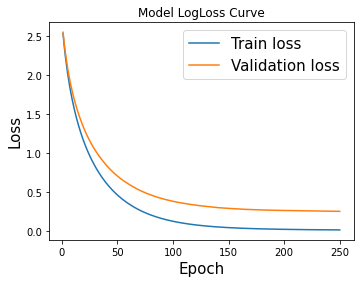

In [27]:
baseline_model = xgb.XGBClassifier(objective='multi:softmax',
                                eval_metric=['merror','mlogloss'],
                                n_estimators = 250,
                                eta=0.03,
                                use_label_encoder=False)
# fit model and get predictions on validation set
baseline_pred = eval_score(baseline_model)
# plot loss curve
eval_graphs(baseline_model)

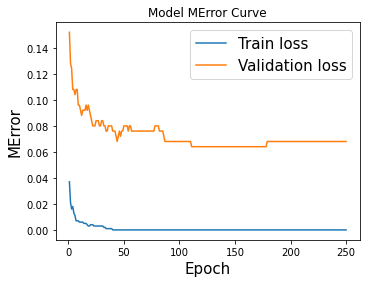

In [28]:
results = baseline_model.evals_result()
x_arr = np.arange(len(results['validation_0']['mlogloss']))+1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, results['validation_0']['merror'], label='Train loss')
ax.plot(x_arr, results['validation_1']['merror'], label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('MError', size=15)
plt.title('Model MError Curve')
plt.show()

### Model Tuning

For work here are the hyperparameters we usually try:
* model complexity:
    * max_depth: integers from 8 to 20
    * min_child_weight: integers from 1 to 100
    * gamma: float between 0 and 4
* randomness:
    * lambda/reg_lambda: log scaling .001 to 1
    * alpha/reg_alpha: log scaling .001 to 10
    * learning_rate: log scaling .01 to 1
    * subsample: float between 0.2 and 1
    * colsample_bytree, colsample_bylevel, colsample_bynode: for each, floats between 0.3 and 1

There are obviously a ton of different possible combinations here, so we use gridSearch pick the more important ones to test. I would just set learning rate at 0.01 and try changing the max_depth & min_child_weight parameters first.

accuracy|eta|colsample_bytree|gamma|max_depth|min_child_weight|reg_alpha|reg_lambda
--------|---|----------------|-----|---------|----------------|---|--
0.884 | 0.3 | 0.8166109190737193|1.3524019417422217 | 9 | 3 | 40 | 0.38875374236059673
0.92|0.3|0.7332967013192906|1.180637520546325|10|3|0.0|0.665768265241745
0.94|0.3|0.4718126556989784|1.1448126444222648|7|7|0.0|0.9968450328215387
0.92|0.6233550058931083|1.0|3.125965168028287|9|6|0.6278402276742281|2.750270104431137

In [24]:
# parameters that increase model complexity
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# initialize domain space for range of values
space={'max_depth': hp.quniform("max_depth", 8, 20, 1),
       'min_child_weight' : hp.quniform('min_child_weight', 1, 100, 1),
       'gamma': hp.uniform ('gamma', 0, 4)
        }

# define objective function
def objective(space):
    clf=xgb.XGBClassifier(objective='multi:softmax',
                          eta=0.3,
                          num_class=15,
                          eval_metric=['merror','mlogloss'],
                          n_estimators =250,
                          max_depth = int(space['max_depth']), 
                          min_child_weight=int(space['min_child_weight']),
                          gamma = space['gamma'],
                          use_label_encoder=False)
    
    evaluation = [(x_tr, y_tr), (x_val, y_val)]
    # early stopping
    clf.fit(x_tr, y_tr,
            eval_set=evaluation,
            early_stopping_rounds=10,
            verbose=0)
    
    pred = clf.predict(x_val)
    accuracy = accuracy_score(y_val, pred)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

# optimization algorithm
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

# print results
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

SCORE:                                                                          
0.7                                                                             
  1%|▏                   | 1/100 [05:43<9:27:01, 343.65s/trial, best loss: -0.7]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.736                                                                           
  2%|▎                 | 2/100 [11:19<9:13:32, 338.91s/trial, best loss: -0.736]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.928                                                                           
  3%|▌                 | 3/100 [14:30<7:18:33, 271.27s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.736                                                                           
  4%|▋                 | 4/100 [20:23<8:06:05, 303.81s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.748                                                                           
  5%|▉                 | 5/100 [25:46<8:11:37, 310.50s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.824                                                                           
  6%|█                 | 6/100 [31:53<8:36:30, 329.69s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.9                                                                             
  7%|█▎                | 7/100 [40:06<9:53:53, 383.15s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.764                                                                           
  8%|█▍                | 8/100 [46:28<9:47:13, 382.97s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.912                                                                           
  9%|█▌               | 9/100 [53:46<10:06:44, 400.05s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.748                                                                           
 10%|█▋               | 10/100 [59:28<9:33:21, 382.24s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.736                                                                           
 11%|█▋             | 11/100 [1:05:06<9:06:54, 368.70s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.76                                                                            
 12%|█▊             | 12/100 [1:12:05<9:23:04, 383.91s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.712                                                                           
 13%|█▉             | 13/100 [1:17:30<8:50:44, 366.03s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.748                                                                           
 14%|██             | 14/100 [1:23:06<8:31:42, 357.00s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.656                                                                           
 15%|██▎            | 15/100 [1:28:58<8:23:30, 355.42s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.92                                                                            
 16%|██▍            | 16/100 [1:36:04<8:47:26, 376.74s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.644                                                                           
 17%|██▌            | 17/100 [1:42:09<8:36:25, 373.32s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.924                                                                           
 18%|██▌           | 18/100 [1:52:04<10:00:53, 439.68s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.892                                                                           
 19%|██▋           | 19/100 [1:59:57<10:07:10, 449.76s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.804                                                                           
 20%|███            | 20/100 [2:06:25<9:34:50, 431.13s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.908                                                                           
 21%|██▉           | 21/100 [2:18:07<11:14:44, 512.46s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.908                                                                           
 22%|███           | 22/100 [2:44:40<18:08:04, 836.98s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.92                                                                            
 23%|███▏          | 23/100 [2:52:48<15:39:28, 732.05s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.924                                                                           
 24%|███▎          | 24/100 [2:59:51<13:29:46, 639.29s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.9                                                                             
 25%|███▌          | 25/100 [3:08:05<12:24:42, 595.77s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.936                                                                           
 26%|███▋          | 26/100 [3:17:11<11:56:24, 580.87s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.916                                                                           
 27%|███▊          | 27/100 [3:25:03<11:06:53, 548.13s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.912                                                                           
 28%|███▉          | 28/100 [3:39:34<12:54:12, 645.17s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.924                                                                           
 29%|████          | 29/100 [3:47:31<11:43:37, 594.62s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.908                                                                           
 30%|████▏         | 30/100 [3:54:30<10:32:17, 541.96s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.896                                                                           
 31%|████▎         | 31/100 [4:03:46<10:27:55, 546.03s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.848                                                                           
 32%|████▊          | 32/100 [4:10:51<9:38:00, 510.01s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.92                                                                            
 33%|████▌         | 33/100 [4:26:53<12:00:54, 645.59s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.888                                                                           
 34%|████▊         | 34/100 [4:33:37<10:30:11, 572.90s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.928                                                                           
 35%|█████▎         | 35/100 [4:41:07<9:40:48, 536.13s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.908                                                                           
 36%|█████▍         | 36/100 [4:48:25<9:00:25, 506.65s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.912                                                                           
 37%|█████▌         | 37/100 [4:55:49<8:32:20, 487.94s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.936                                                                           
 38%|█████▋         | 38/100 [5:03:48<8:21:14, 485.06s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.78                                                                            
 39%|█████▊         | 39/100 [5:11:09<7:59:43, 471.86s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.932                                                                           
 40%|██████         | 40/100 [5:13:59<6:21:22, 381.38s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.744                                                                           
 41%|██████▏        | 41/100 [5:20:53<6:24:38, 391.17s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.912                                                                           
 42%|██████▎        | 42/100 [5:31:26<7:28:12, 463.67s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.864                                                                           
 43%|██████▍        | 43/100 [5:38:58<7:17:12, 460.22s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.896                                                                           
 44%|██████▌        | 44/100 [5:48:39<7:43:15, 496.35s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.908                                                                           
 45%|██████▊        | 45/100 [6:00:33<8:34:52, 561.68s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.912                                                                           
 46%|██████▍       | 46/100 [6:23:25<12:04:19, 804.80s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.844                                                                           
 47%|██████▌       | 47/100 [6:31:13<10:21:47, 703.91s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.896                                                                           
 48%|███████▏       | 48/100 [6:40:10<9:26:32, 653.71s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.908                                                                           
 49%|███████▎       | 49/100 [6:47:18<8:18:10, 586.09s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.768                                                                           
 50%|███████▌       | 50/100 [6:53:54<7:20:51, 529.02s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.912                                                                           
 51%|███████▋       | 51/100 [6:57:07<5:49:46, 428.29s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.912                                                                           
 52%|███████▊       | 52/100 [7:05:27<5:59:44, 449.67s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.916                                                                           
 53%|███████▉       | 53/100 [7:12:09<5:41:07, 435.48s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.728                                                                           
 54%|████████       | 54/100 [7:17:15<5:04:07, 396.67s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.908                                                                           
 55%|████████▎      | 55/100 [7:24:56<5:12:00, 416.00s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.932                                                                           
 56%|████████▍      | 56/100 [7:32:35<5:14:23, 428.71s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.9                                                                             
 57%|████████▌      | 57/100 [7:38:37<4:53:02, 408.89s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.808                                                                           
 58%|████████▋      | 58/100 [7:44:27<4:33:46, 391.10s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.912                                                                           
 59%|████████▊      | 59/100 [8:03:21<6:59:28, 613.86s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.908                                                                           
 60%|█████████      | 60/100 [8:11:04<6:19:13, 568.84s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.916                                                                           
 61%|█████████▏     | 61/100 [8:19:52<6:01:45, 556.55s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.892                                                                           
 62%|█████████▎     | 62/100 [8:25:45<5:13:49, 495.51s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.744                                                                           
 63%|█████████▍     | 63/100 [8:31:24<4:36:26, 448.30s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.904                                                                           
 64%|█████████▌     | 64/100 [8:38:33<4:25:37, 442.71s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.908                                                                           
 65%|█████████▊     | 65/100 [8:44:34<4:03:50, 418.01s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.924                                                                           
 66%|█████████▉     | 66/100 [8:51:16<3:54:18, 413.49s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.936                                                                           
 67%|██████████     | 67/100 [8:57:50<3:44:10, 407.60s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.928                                                                           
 68%|██████████▏    | 68/100 [9:04:26<3:35:27, 404.00s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.936                                                                           
 69%|██████████▎    | 69/100 [9:13:05<3:46:33, 438.49s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.924                                                                           
 70%|██████████▌    | 70/100 [9:15:17<2:53:18, 346.63s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.92                                                                            
 71%|██████████▋    | 71/100 [9:17:52<2:19:44, 289.13s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.912                                                                           
 72%|██████████▊    | 72/100 [9:25:26<2:37:59, 338.54s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.916                                                                           
 73%|██████████▉    | 73/100 [9:29:47<2:21:51, 315.25s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.908                                                                           
 74%|███████████    | 74/100 [9:35:48<2:22:36, 329.10s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.908                                                                           
 75%|███████████▎   | 75/100 [9:42:00<2:22:29, 341.98s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.928                                                                           
 76%|███████████▍   | 76/100 [9:46:59<2:11:37, 329.08s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.904                                                                           
 77%|███████████▌   | 77/100 [9:53:07<2:10:34, 340.62s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.908                                                                           
 78%|███████████▋   | 78/100 [9:59:08<2:07:09, 346.81s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.9                                                                             
 79%|███████████   | 79/100 [10:05:16<2:03:34, 353.07s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.924                                                                           
 80%|███████████▏  | 80/100 [10:15:22<2:22:59, 428.95s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.916                                                                           
 81%|███████████▎  | 81/100 [10:17:33<1:47:31, 339.56s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.884                                                                           
 82%|███████████▍  | 82/100 [10:23:29<1:43:24, 344.69s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.912                                                                           
 83%|███████████▌  | 83/100 [10:29:30<1:38:58, 349.30s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.92                                                                            
 84%|███████████▊  | 84/100 [10:33:00<1:22:01, 307.57s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.764                                                                           
 85%|███████████▉  | 85/100 [10:38:41<1:19:23, 317.59s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.892                                                                           
 86%|████████████  | 86/100 [10:44:37<1:16:49, 329.28s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.836                                                                           
 87%|████████████▏ | 87/100 [10:50:25<1:12:30, 334.68s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.916                                                                           
 88%|████████████▎ | 88/100 [10:56:48<1:09:51, 349.33s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.932                                                                           
 89%|████████████▍ | 89/100 [11:03:54<1:08:15, 372.35s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.924                                                                           
 90%|████████████▌ | 90/100 [11:11:43<1:06:52, 401.29s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.916                                                                           
 91%|████████████▋ | 91/100 [11:22:24<1:10:59, 473.27s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.888                                                                           
 92%|██████████████▋ | 92/100 [11:28:18<58:20, 437.54s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.908                                                                           
 93%|██████████████▉ | 93/100 [11:34:18<48:19, 414.23s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.904                                                                           
 94%|███████████████ | 94/100 [11:40:27<40:03, 400.62s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.9                                                                             
 95%|███████████████▏| 95/100 [11:48:03<34:46, 417.33s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.908                                                                           
 96%|███████████████▎| 96/100 [11:55:49<28:46, 431.70s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.808                                                                           
 97%|███████████████▌| 97/100 [12:01:43<20:25, 408.50s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.932                                                                           
 98%|███████████████▋| 98/100 [12:05:22<11:43, 351.77s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.916                                                                           
 99%|███████████████▊| 99/100 [12:13:04<06:24, 384.73s/trial, best loss: -0.936]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.924                                                                           
100%|███████████████| 100/100 [12:21:25<00:00, 444.86s/trial, best loss: -0.936]
The best hyperparameters are :  

{'gamma': 0.023174975386959007, 'max_depth': 14.0, 'min_child_weight': 15.0}


### Model evaluation

Training Set Accuracy Score on EMPO 3:  0.924
Baseline Model Training Time: 1213.2843372821808s


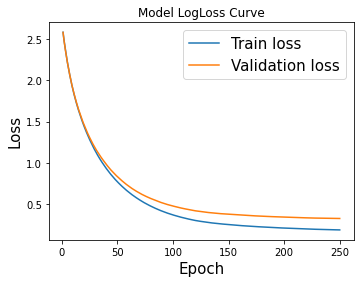

In [33]:
# Parameters for best and final model
best_model=xgb.XGBClassifier(objective='multi:softmax',
                             eta=0.03,
                             num_class=15,
                             eval_metric=['merror','mlogloss'],
                             n_estimators =250,
                             max_depth = 14,
                             min_child_weight=15,
#                              reg_lambda=1,
#                              reg_alpha = 0,
                             gamma = 0.023174975386959007,
#                              colsample_bytree=0.4718126556989784,
                             use_label_encoder=False
                             )

# fit model and get predictions on validation set
best_pred = eval_score(best_model)
# plot loss curve
eval_graphs(best_model)

Comparing the final model and the baseline model, the final model has a smaller difference between the train and validation loss. Thus, we will use the final model parameters.

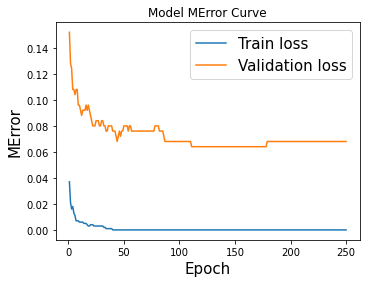

In [35]:
results = baseline_model.evals_result()
x_arr = np.arange(len(results['validation_0']['mlogloss']))+1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, results['validation_0']['merror'], label='Train loss')
ax.plot(x_arr, results['validation_1']['merror'], label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('MError', size=15)
plt.title('Model MError Curve')
plt.show()

### Retrain best model
After experimenting with models, retrain your favorite model using entire training set (including validation) before saving

In [38]:
start = time.time() 
# fit to entire training dataset
baseline_model.fit(x_train, y_train['EMPO_3'],
                eval_set=[(x_train, y_train['EMPO_3'])],
                verbose=0)
stop = time.time()
print(baseline_model)
print(f"Model Training Time: {stop-start}s" )

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.03, eval_metric=['merror', 'mlogloss'], gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.0299999993, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=250, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False, ...)
Model Training Time: 3232.886157989502s


### Save fitted model

In [39]:
# Save best model as joblib or pkl file to 'model_joblibs' folder
dump(best_model, '../model_joblibs/xgb_empo3_baseline.joblib')

['../model_joblibs/xgb_empo3_baseline.joblib']